In [1]:
import os 
import pandas as pd
import PIL
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
from skimage import io
import tensorflow as tf
from importlib import reload
import hashlib
from collections import defaultdict
import shutil
import numpy as np
from tensorflow.keras import layers, models
import utils as ut

ModuleNotFoundError: No module named 'skimage'

## Project and Motivation:

We are interested in building a medical imaging classification model to assist radiologists in detecting and classifying brain tumors from MRI scans. Brain tumors can be life-threatening, and early detection is crucial for effective treatment. However, interpreting MRI scans requires significant expertise and time, which can lead to delays in diagnosis. By developing an automated classification system, we aim to provide a tool that can help radiologists quickly identify potential tumors and their types, thereby improving patient outcomes.

Our motivation is primarily educational, as this project allows us to apply machine learning techniques to a real-world medical problem. Working with image data and medical datasets presents unique challenges, such as handling high-dimensional data, dealing with class imbalances, and ensuring model interpretability. Through this project, we hope to gain hands-on experience in these areas while contributing to a field that has the potential to make a significant impact on healthcare.

## Dataset Overview:


The dataset used in this project is the Brain Tumor MRI Dataset available on Kaggle: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data

It was compiled by Masoud Nickparvar and is composed of images aggregated from three publicly available open-source datasets. While the exact sources are not explicitly documented, the dataset appears to contain real MRI scans of human brains rather than synthetic or GAN-generated images.

Because it combines data from multiple sources, the collection exhibits some heterogeneity in image quality, resolution, and orientation. Additionally, the dataset lacks metadata such as scan parameters or orientation labels, which poses a limitation for detailed analysis. As a result, we must make reasonable assumptions during our exploratory data analysis (EDA) and modeling process to account for potential differences in scan orientation and acquisition settings.

In [4]:
train_path = "archive/Training"

# Create dataset
training_dataset = tf.keras.utils.image_dataset_from_directory(
    train_path,
    labels="inferred",       # infer labels from subfolder names
    label_mode="categorical",        
    image_size=(224, 224),   # resize all images
    batch_size=32,           # number of images per batch
    shuffle=True,            # shuffle data
    seed=42                  # for reproducibility
)

# Check class names
print("Classes found:", training_dataset.class_names)

class_names = training_dataset.class_names
counts = []

for class_name in class_names:
    class_dir = os.path.join(train_path, class_name)
    num_images = len([f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    counts.append(num_images)

# Create and display the DataFrame
df_class_counts = pd.DataFrame({
    "Tumor Type": class_names,
    "Image Count": counts
})

print("Training Folder Class Distribution:")
display(df_class_counts)



Found 5712 files belonging to 4 classes.
Classes found: ['glioma', 'meningioma', 'notumor', 'pituitary']
Training Folder Class Distribution:


,Tumor Type,Image Count
0,glioma,1321
1,meningioma,1339
2,notumor,1595
3,pituitary,1457


In [5]:
test_path = "archive/Testing"

testing_dataset = tf.keras.utils.image_dataset_from_directory(
    test_path,
    labels="inferred",       # infer labels from subfolder names
    label_mode="categorical",        # can also use "categorical" or "binary"
    image_size=(224, 224),   # resize all images
    batch_size=32,           # number of images per batch
    shuffle=True,            # shuffle data
    seed=42                  # for reproducibility
)   
# Check class names
print("Classes found:", testing_dataset.class_names)

class_names = testing_dataset.class_names
counts = []

for class_name in class_names:
    class_dir = os.path.join(test_path, class_name)
    num_images = len([f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    counts.append(num_images)

# Create and display the DataFrame
df_class_counts = pd.DataFrame({
    "Tumor Type": class_names,
    "Image Count": counts
})

print("Testing Folder Class Distribution:")
display(df_class_counts)

Found 1311 files belonging to 4 classes.
Classes found: ['glioma', 'meningioma', 'notumor', 'pituitary']
Testing Folder Class Distribution:


,Tumor Type,Image Count
0,glioma,300
1,meningioma,306
2,notumor,405
3,pituitary,300


## PreProcessing:

### Detecting Duplicates:


The first step in cleaning up this datset is detecting and removing duplicate images. Because this dataset was aggregated from multiple sources, there is a high likelihood of duplicate images being present. Duplicates can introduce bias and redundancy, which can negatively impact model training and evaluation. To identify duplicates, we can use image hashing techniques that generate a unique hash value for each image based on its pixel content. By comparing hash values, we can efficiently detect identical or near-identical images. 

Found 148 sets of exact duplicates.


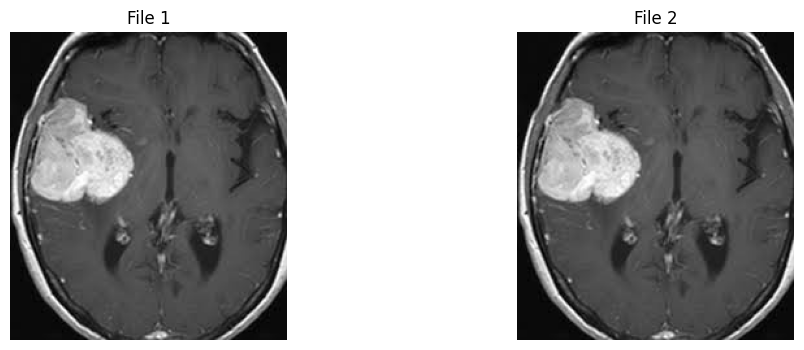

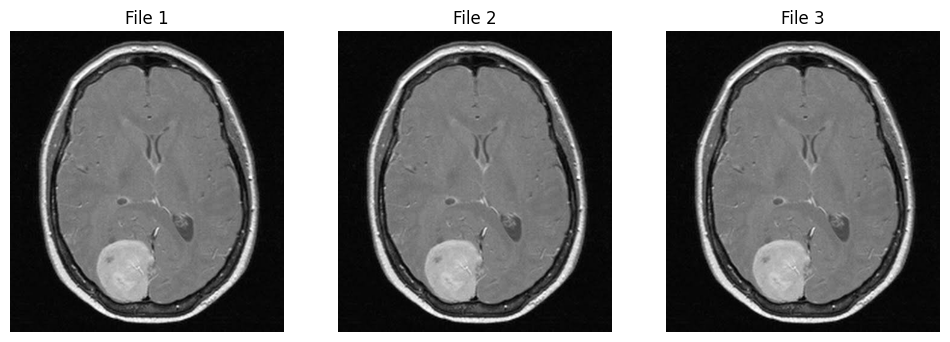

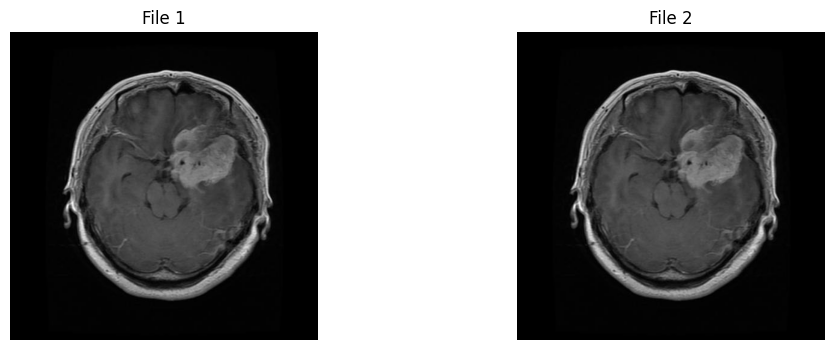

In [6]:
train_duplicates = ut.find_and_visualize_duplicates(train_path)

Found 18 sets of exact duplicates.


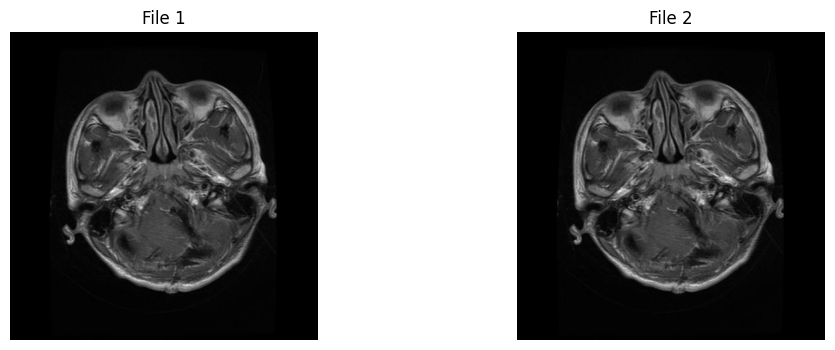

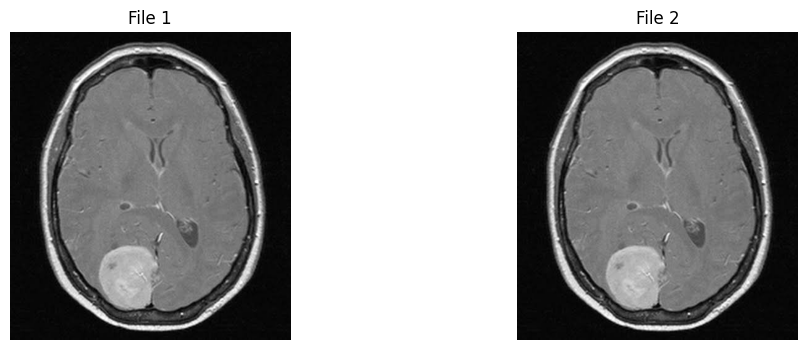

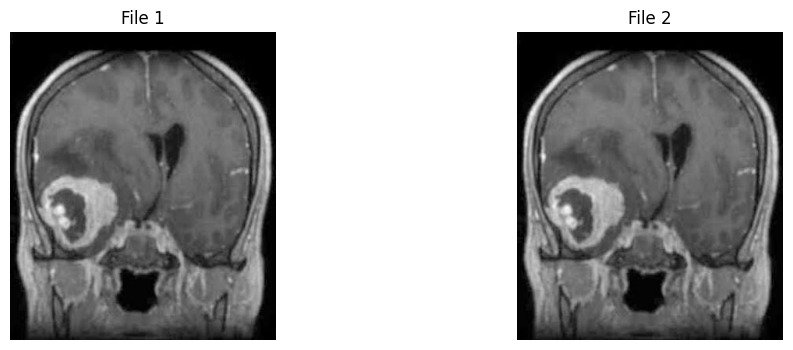

In [7]:
test_duplicates = ut.find_and_visualize_duplicates(test_path)

We first remove all duplicates found from both the train and test sets individually.

After removing duplicates within each set, the training folder went from having 5712 images to 5521 image, and the testing folder went from having 1311 images to 1284 images.

In [8]:
# Flatten all duplicate file paths to remove (keep first file in each set)
train_files_to_remove = set()
for paths in train_duplicates.values():
    train_files_to_remove.update(paths[1:])  # keep first file, remove others

good_train_image_paths = []
for root, _, files in os.walk(train_path):
    for f in files:
        if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")):
            full_path = os.path.join(root, f)
            if full_path not in train_files_to_remove:
                good_train_image_paths.append(full_path)

new_base_folder = "archive-2/Filtered_Training"
ut.create_filtered_dataset(good_train_image_paths, new_base_folder)

Created new dataset at archive-2/Filtered_Training with 5521 images.


In [9]:
test_files_to_remove = set()
for paths in test_duplicates.values():
    test_files_to_remove.update(paths[1:])  # keep first file, remove others

good_test_image_paths = []
for root, _, files in os.walk(test_path):
    for f in files:
        if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")):
            full_path = os.path.join(root, f)
            if full_path not in test_files_to_remove:
                good_test_image_paths.append(full_path)

new_base_folder = "archive-2/Filtered_Testing"
ut.create_filtered_dataset(good_test_image_paths, new_base_folder)


Created new dataset at archive-2/Filtered_Testing with 1284 images.


Next, just to be safe, we check for any duplicates that may exist across the training and testing sets. Any such duplicates found are removed from the testing set to ensure that the test data remains completely unseen during model training.

Found 79 sets of duplicates across folders.


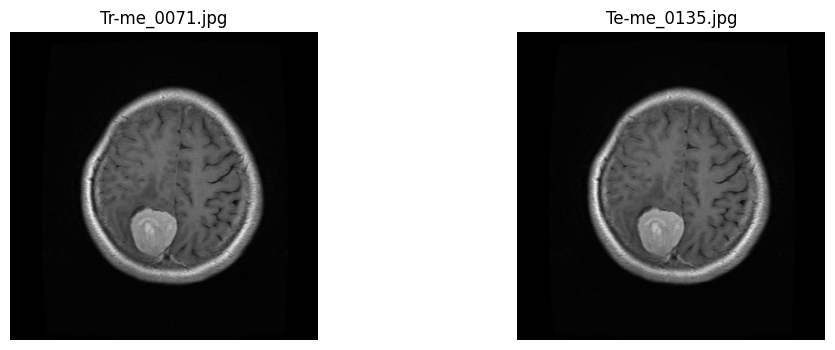

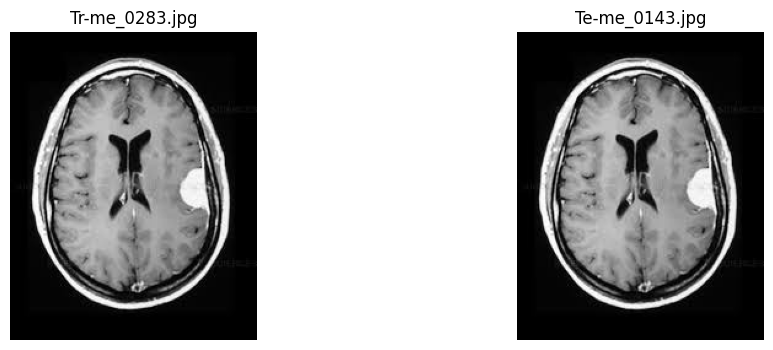

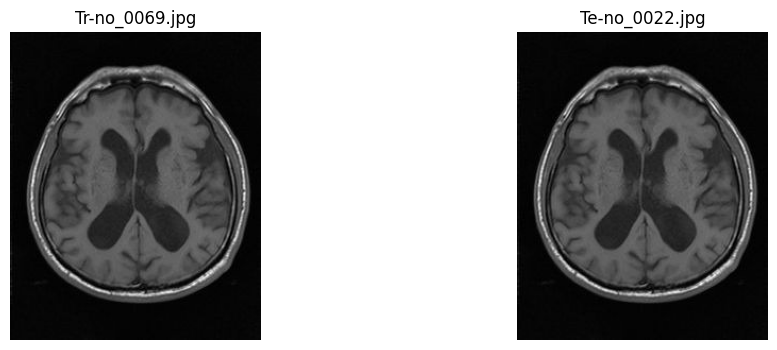

In [10]:
filtered_train_path = "archive-2/Filtered_Training"
filtered_test_path = "archive-2/Filtered_Testing"
duplicates_across_train_and_test = ut.find_duplicates_across_folders(filtered_train_path, filtered_test_path)

In [11]:

more_test_files_to_remove = set()
for paths in duplicates_across_train_and_test.values():
    for p in paths:
        if p.startswith(filtered_test_path):  # only remove from test folder
            more_test_files_to_remove.add(p)

good_test_image_paths = []
for root, _, files in os.walk(filtered_test_path):
    for f in files:
        if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")):
            full_path = os.path.join(root, f)
            if full_path not in more_test_files_to_remove:
                good_test_image_paths.append(full_path)
                
new_base_folder = "archive-2/Final_Filtered_Testing"
ut.create_filtered_dataset(good_test_image_paths, new_base_folder)

print(f"Removed {len(more_test_files_to_remove)} duplicate files from the test set.")


Created new dataset at archive-2/Final_Filtered_Testing with 1205 images.
Removed 79 duplicate files from the test set.


Now, the final filtered test set contains 1205 images after removing duplicates that were also present in the training set.

In [12]:
filtered_train_path = "archive-2/Filtered_Training"
filtered_test_path = "archive-2/Final_Filtered_Testing"
duplicates_across_train_and_test = ut.find_duplicates_across_folders(filtered_train_path, filtered_test_path)

Found 0 sets of duplicates across folders.


In [13]:
ut.find_and_visualize_duplicates(filtered_train_path)

Found 0 sets of exact duplicates.


{}

In [14]:
ut.find_and_visualize_duplicates(filtered_test_path)

Found 0 sets of exact duplicates.


{}

In [15]:
# Filtered Training Counts 
filtered_train_path = "archive-2/Filtered_Training"
train_class_counts = ut.get_class_distribution(filtered_train_path)

# Final Filtered Testing Counts
final_filtered_test_path = "archive-2/Final_Filtered_Testing"
test_class_counts = ut.get_class_distribution(final_filtered_test_path)


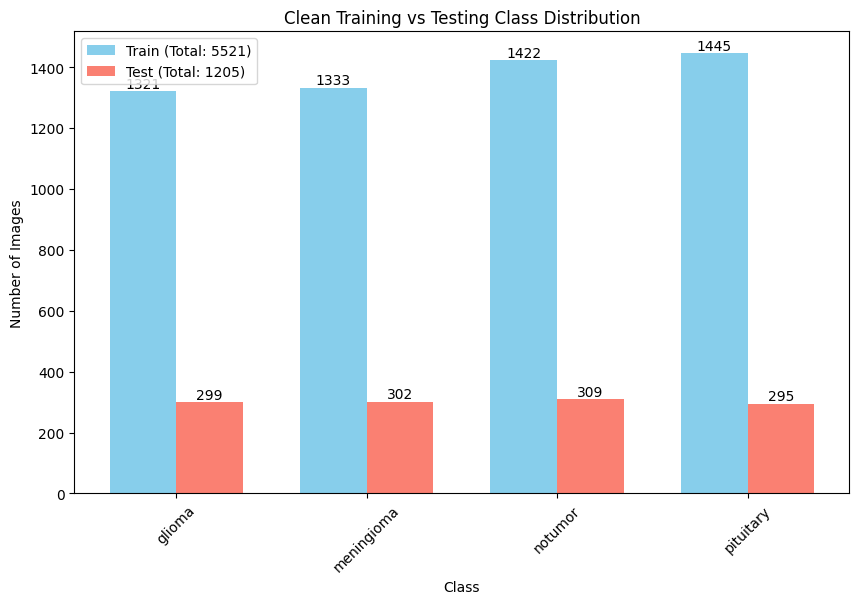

In [16]:
classes = list(train_class_counts.keys())
train_counts = [train_class_counts[c] for c in classes]
test_counts = [test_class_counts[c] for c in classes]

x = np.arange(len(classes))  # label locations
width = 0.35  # width of the bars

# Compute totals
total_train = sum(train_counts)
total_test = sum(test_counts)

plt.figure(figsize=(10, 6))
bars1 = plt.bar(x - width/2, train_counts, width, label=f'Train (Total: {total_train})', color='skyblue')
bars2 = plt.bar(x + width/2, test_counts, width, label=f'Test (Total: {total_test})', color='salmon')

# Add counts on top of each bar
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, str(height), ha='center', va='bottom', fontsize=10)
for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, str(height), ha='center', va='bottom', fontsize=10)

plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Clean Training vs Testing Class Distribution")
plt.xticks(x, classes, rotation=45)
plt.legend()
plt.show()


### Next We Resize and Convert all Images to grey scale:

We convert to greycale to reduce complexity and focus on structural features relevant for tumor detection and not color. 

In [17]:
reload(ut)
filtered_train_path = "archive-2/Filtered_Training"
grayscale_train_path = "archive-2/Grayscale_Training"

final_filtered_test_path = "archive-2/Final_Filtered_Testing"
grayscale_test_path = "archive-2/Grayscale_Testing"

ut.resize_and_convert_to_grayscale(filtered_train_path, grayscale_train_path, target_size=(224, 224))
ut.resize_and_convert_to_grayscale(final_filtered_test_path, grayscale_test_path, target_size=(224, 224))


Processed images saved to archive-2/Grayscale_Training
Processed images saved to archive-2/Grayscale_Testing


There are some inconsistencies in image sizes acorss the dataset. To ensure uniformity, we resize all images to a standard dimension of 224x224 pixels. This size is commonly used in many pre-trained convolutional neural networks (CNNs) and provides a good balance between computational efficiency and retaining important image details.

### Exploring the Orientation Distribution of the MRI Scans: 

One thing we noticed, with the help of professor Giritharan, is that the MRI scans in this dataset represnt a variety of different orientations (axial, sagittal, coronal). However, the dataset does not provide explicit labels indicating the orientation of each scan.

We need to make sure that each class of tumor is represented across all orientations in both the training and testing sets. If certain classes are predominantly represented in one orientation, it could lead to biased model performance.

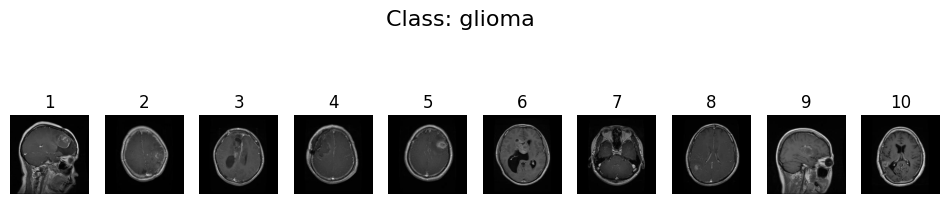

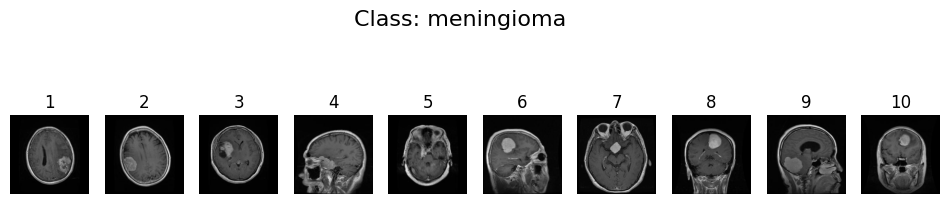

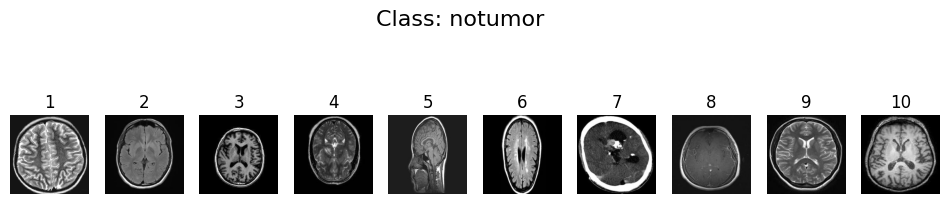

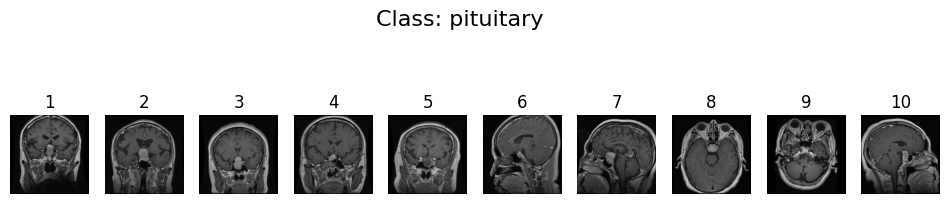

In [18]:
reload(ut)
ut.show_random_samples_per_class(grayscale_train_path, samples_per_class=10)

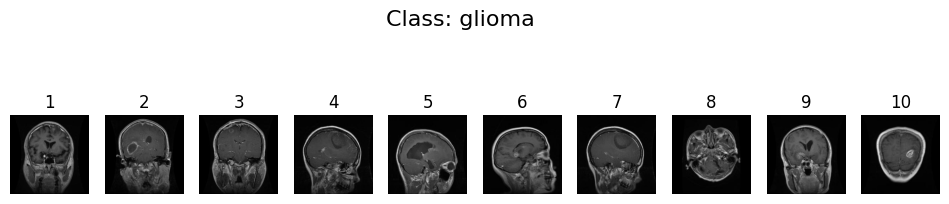

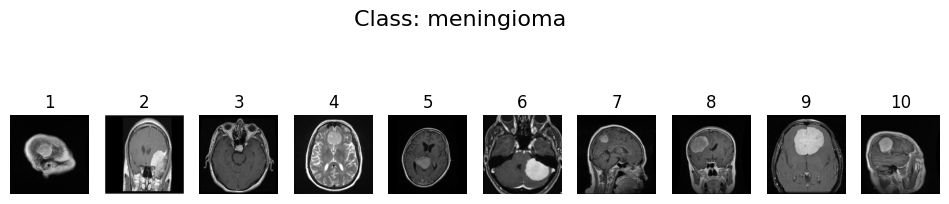

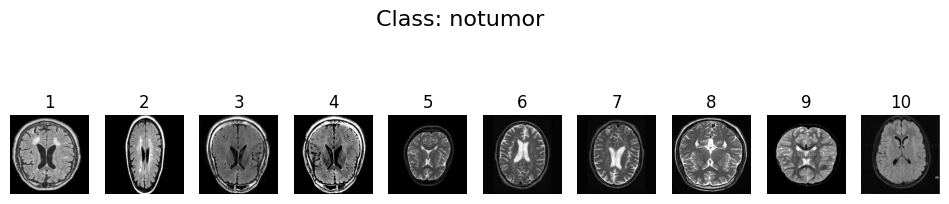

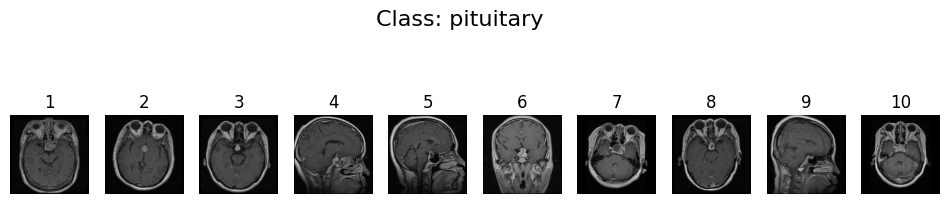

In [19]:
reload(ut)
ut.show_random_samples_per_class(grayscale_test_path, samples_per_class=10)

### Orientation Imbalnce: 

Through EDA, we have found that this dataset has significant orientation imbalace. Most of the images in the no tumor class are axial images, while sagittal and coronal images are underrepresented. The glioma class seems to have a more balanced distrbibution of orientations. Likewise, so does the pituitary class. Likewise so does the mengioma class. 

Right now we are exploring different techniques to address this orientation imbalance, such as data augmentation or stratified sampling during train-test splitting, but have not yet finalized our approach. It is also possible that we may proceed without any special handling of orientation imbalance, depending on how it impacts model performance during initial experiments. We can evaluate this by monitoring evaluation metrics across different orientations once we have a working model pipeline. 

The dream would be to balance orientations across all classes but this may not be feasible given the current dataset composition.
We plan to also explore stratifying the train test splits (after the 2 folders are combined) on both class and orientation to ensure balanced representation in both sets.

## Outlier Detection: 

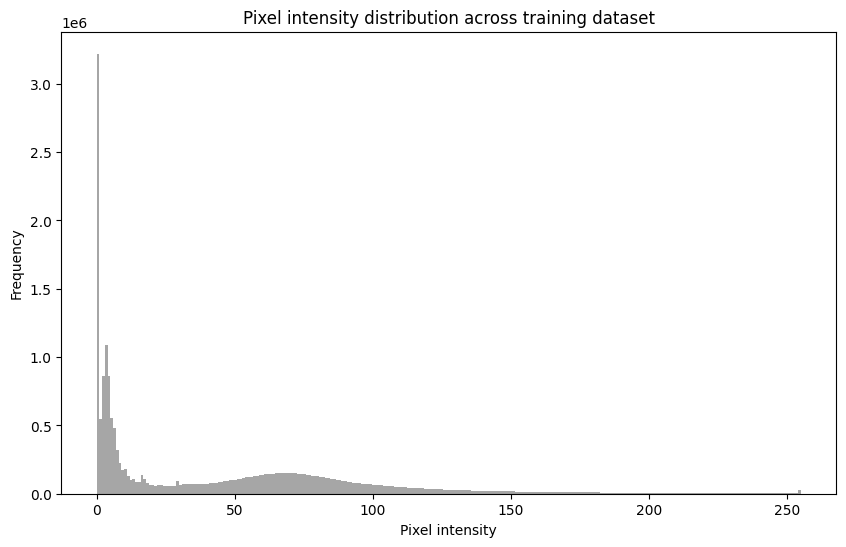

In [20]:
reload(ut)
filtered_train_path = "archive-2/Grayscale_Training"
ut.plot_pixel_distribution(filtered_train_path, sample_limit=100)  


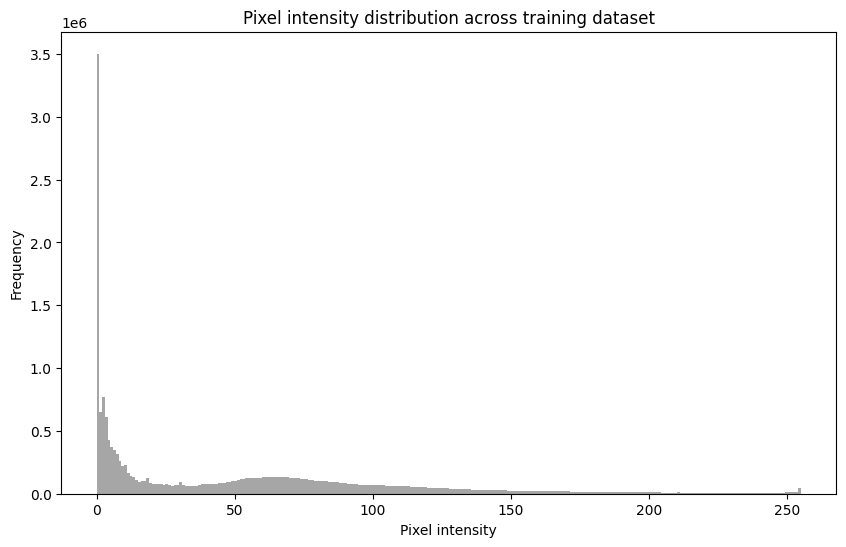

In [21]:
reload(ut)
filtered_test_path = "archive-2/Grayscale_Testing"
ut.plot_pixel_distribution(filtered_test_path, sample_limit=100) 

We can see that the pixel distribution of the images is skewed due to the fact that most of the images have a lot of black background pixels. To address this, we will perform outlier detection based on pixel intensity statistics while ignoring the black background pixels.

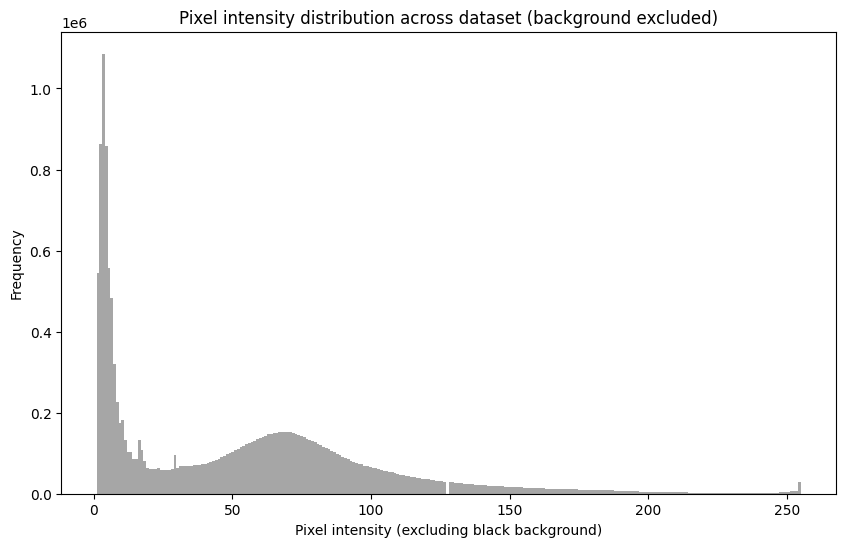

In [22]:
reload(ut)
filtered_train_path = "archive-2/Grayscale_Training"
ut.plot_pixel_distribution_no_background(filtered_train_path, sample_limit=100)  

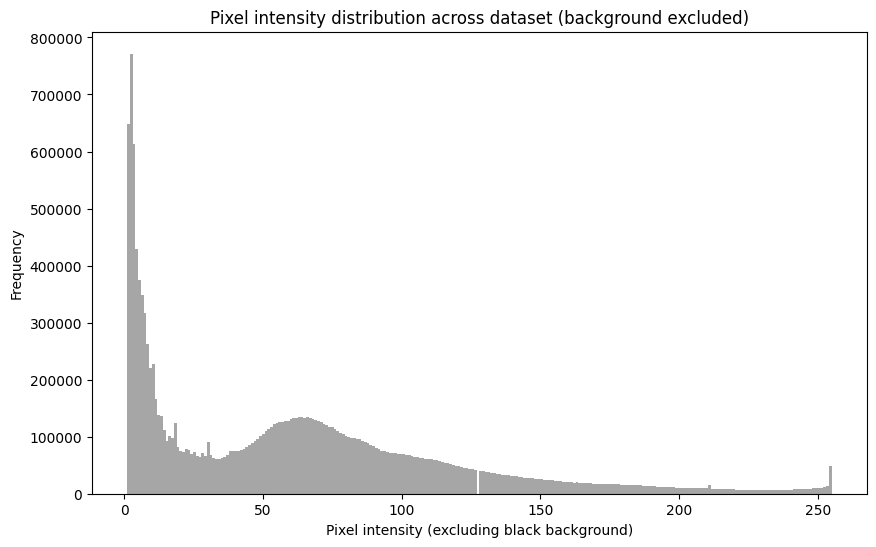

In [23]:
reload(ut)
filtered_test_path = "archive-2/Grayscale_Testing"
ut.plot_pixel_distribution_no_background(filtered_test_path, sample_limit=100) 

Based on the histograms above, we can see that most of the pixel intensities (excluding black background pixels) fall within the range of 0 to 150. Therefore, we could set thresholds for outlier detection based on this range. For example, we can consider pixels with intensities below 10 or above 140 as potential outliers.

But at this time, we conlude there is not a significant number of outliers in the dataset that would warrant removal or special handling. The pixel intensity distributions appear to be relatively consistent across the images, aside from the expected variations due to different tumor types and imaging conditions.

## Image Augmentation:

Now, we want to apply image augmentation techniques to artificially increase the diversity of our training dataset. This can help improve the model's ability to generalize to unseen data. Common augmentation techniques include rotations, flips, zooms, and shifts. We leave the testing set untouched. 

We do this with the help of Tensor Flow's documentation. 
TensorFlow. (2024, July 19). Data augmentation. TensorFlow Core.
https://www.tensorflow.org/tutorials/images/data_augmentation

In [24]:
train_path = "archive-2/Grayscale_Training"

# Create tf dataset
training_dataset = tf.keras.utils.image_dataset_from_directory(
    train_path,
    labels="inferred",       # infer labels from subfolder names
    label_mode="categorical",        
    image_size=(224, 224),   # resize all images
    batch_size=32,           # number of images per batch
    shuffle=True,            # shuffle data
    seed=42                  # for reproducibility
)

test_path = "archive-2/Grayscale_Testing"

testing_dataset = tf.keras.utils.image_dataset_from_directory(
    test_path,
    labels="inferred",       # infer labels from subfolder names
    label_mode="categorical",        
    image_size=(224, 224),   # resize all images
    batch_size=32,           # number of images per batch
    shuffle=True,            # shuffle data
    seed=42                  # for reproducibility
)


Found 5521 files belonging to 4 classes.
Found 1205 files belonging to 4 classes.


In [25]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2, fill_mode="nearest")
])

AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)


  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(training_dataset, shuffle=True, augment=True)
test_ds = prepare(testing_dataset)

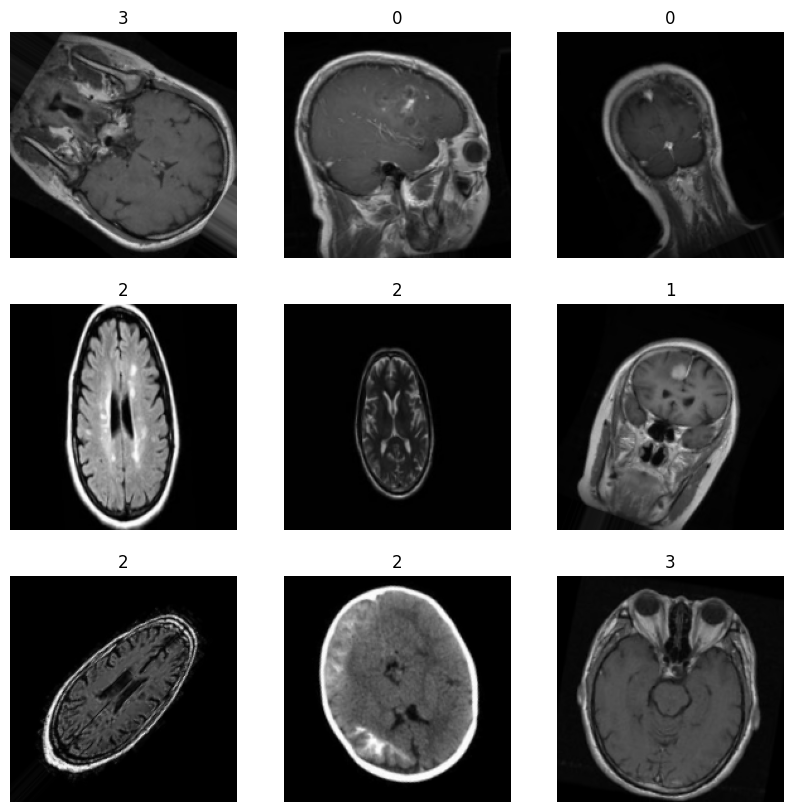

In [26]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        class_idx = tf.argmax(labels[i]).numpy()  # convert one-hot to int
        plt.title(class_idx)
        plt.axis("off")


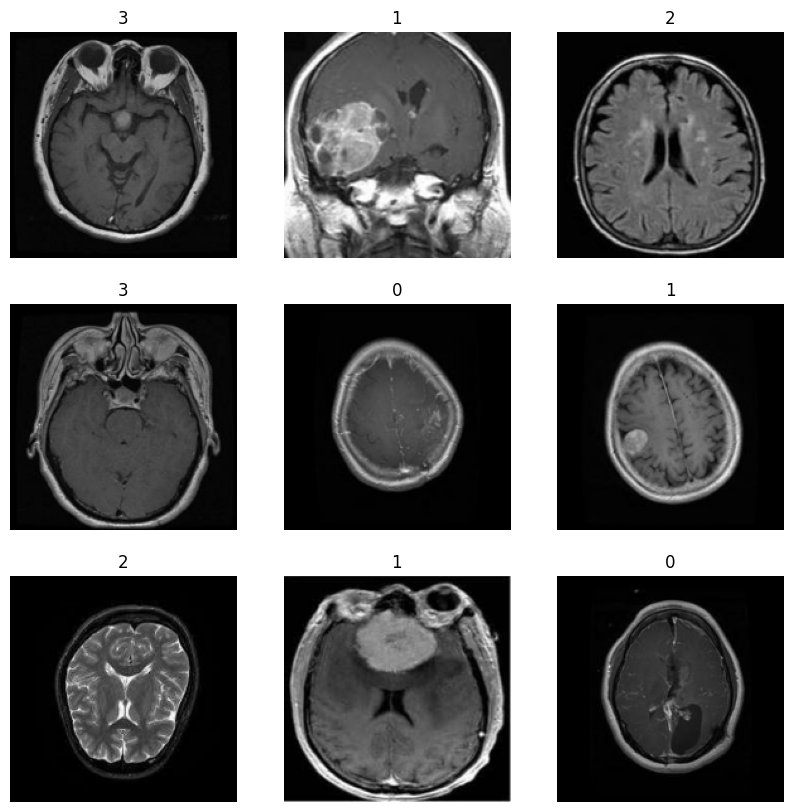

In [27]:
for images, labels in test_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        class_idx = tf.argmax(labels[i]).numpy()  # convert one-hot to int
        plt.title(class_idx)
        plt.axis("off")

## Model Update and Next Steps: 

For our brain tumor detection project using MRI images, we have chosen to implement a convolutional
neural network (CNN) based model, specifically leveraging the ResNet-18 architecture. This model is a
deep learning framework known for its residual connections, which effectively reduce the problem of
vanishing gradients and allow the network to learn richer hierarchical features. The decision to use a
CNN is driven by the nature of MRI images, where spatial and textural features play a critical role in
differentiating tumor types. CNNs have consistently demonstrated strong performance in medical
image analysis tasks, making them ideal for this project. 

The rationale behind choosing ResNet-18 lies in its ability to perform transfer learning from large-scale datasets such as ImageNet, enabling faster convergence and improved accuracy even with limited domain-specific data. Since medical images share fundamental visual features like edges and textures, fine-tuning such a pretrained model helps our network generalize better across different MRI scans. Furthermore, ResNet’s skip connections preserve essential information across layers, ensuring that subtle variations within tumor regions are not lost during the feature extraction process. 

For evaluation, we plan to adopt multiple performance metrics to ensure the model’s reliability and fairness across all classes. In addition to traditional metrics like accuracy, precision, recall, and F1-score, we will include the Matthews Correlation Coefficient (MCC). The MCC is particularly valuable for medical classification problems because it provides a balanced measure even when the dataset is imbalanced. Unlike accuracy, which can be misleading when one class dominates, MCC takes into account true and false positives and negatives, offering a
more complete picture of the model’s predictive power. Our next steps involve refining the dataset to
remove potential sources of bias such as performing additional data augmentation to improve robustness. Once data preprocessing is finalized, we will proceed with fine-tuning the model using cross-validation to ensure consistent performance. We also plan to explore explainable AI techniques, such as Grad-CAM visualizations, to better interpret the model’s predictions and highlight the key MRI regions that contribute to each classification. These steps will help us build a reliable, interpretable, and clinically meaningful system for brain tumor detection.


## Refined Outlier Detection (Per-Image Intensity Statistics)

The earlier histograms gave us a high-level sense of pixel intensity distributions.
To make our outlier analysis more **systematic**, we now:

- Compute **per-image statistics** (mean, median, standard deviation, and extreme quantiles) of non-background pixels.
- Use the **IQR rule** on the distribution of per-image mean intensities to flag outlier images.
- Visualize the distribution of image-level statistics and highlight potential outliers.


In [28]:

import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def collect_image_intensity_stats(root_dir, max_images=400):
    image_paths = []
    for r, _, files in os.walk(root_dir):
        for f in files:
            if f.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")):
                image_paths.append(os.path.join(r, f))
    if len(image_paths) == 0:
        raise ValueError(f"No images found under {root_dir}")
        
    if len(image_paths) > max_images:
        image_paths = random.sample(image_paths, max_images)
    
    stats = {
        "path": [],
        "mean_intensity": [],
        "median_intensity": [],
        "std_intensity": [],
        "p5": [],
        "p95": [],
        "dark_frac": [],    # fraction of pixels <= 10
        "bright_frac": [],  # fraction of pixels >= 245
    }
    
    for p in image_paths:
        im = Image.open(p).convert("L")  # grayscale
        arr = np.array(im).astype("float32")
        
        # Treat 0 as background and ignore it
        fg = arr[arr > 0]
        if fg.size == 0:
            continue
        
        stats["path"].append(p)
        stats["mean_intensity"].append(float(fg.mean()))
        stats["median_intensity"].append(float(np.median(fg)))
        stats["std_intensity"].append(float(fg.std()))
        stats["p5"].append(float(np.percentile(fg, 5)))
        stats["p95"].append(float(np.percentile(fg, 95)))
        stats["dark_frac"].append(float((fg <= 10).mean()))
        stats["bright_frac"].append(float((fg >= 245).mean()))
    
    stats_df = pd.DataFrame(stats)
    return stats_df

# Collect stats for the grayscale training set
train_stats_df = collect_image_intensity_stats(grayscale_train_path, max_images=400)
train_stats_df.describe()


,mean_intensity,median_intensity,std_intensity,p5,p95,dark_frac,bright_frac
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,56.507231,52.466250,46.841894,3.937500,141.358877,0.313570,0.007059
std,22.414163,28.506003,12.731156,4.658632,42.044904,0.141926,0.020604
min,26.136175,1.000000,23.870337,1.000000,69.000000,0.000000,0.000000
25%,43.212954,38.000000,38.259189,2.000000,115.112793,0.222783,0.000000
50%,49.948589,49.000000,43.418810,3.000000,129.000000,0.333921,0.000020
75%,59.669292,61.000000,50.226128,4.000000,147.250000,0.406634,0.000244
max,158.519440,178.000000,96.846420,37.000000,255.000000,0.695519,0.168857


Total sampled images: 400
Potential outlier images (IQR rule): 51


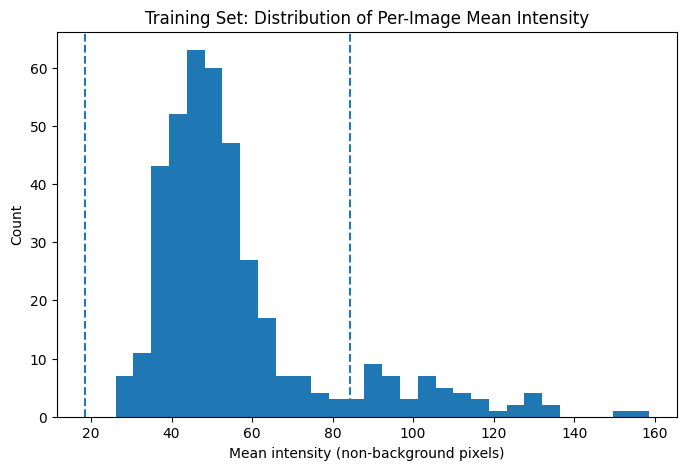

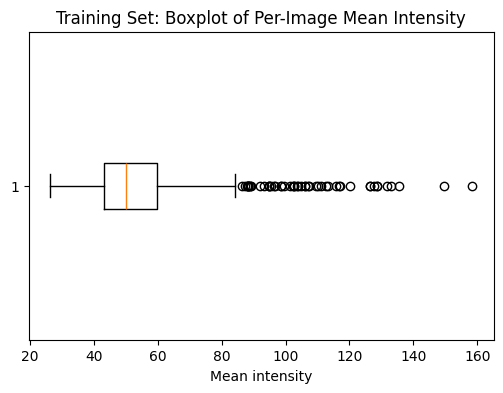


Example potential outliers (training set):


,path,mean_intensity,dark_frac,bright_frac
116,archive-2/Grayscale_Training\notumor\Tr-no_067...,86.307716,0.003670,0.061923
338,archive-2/Grayscale_Training\meningioma\Tr-me_...,87.415695,0.000000,0.007155
333,archive-2/Grayscale_Training\notumor\Tr-no_122...,87.966148,0.128785,0.000441
282,archive-2/Grayscale_Training\notumor\Tr-no_153...,88.141357,0.003707,0.004744
114,archive-2/Grayscale_Training\notumor\Tr-no_069...,88.141792,0.003667,0.004724


In [29]:

# IQR-based outlier detection on per-image mean intensity
q1 = train_stats_df["mean_intensity"].quantile(0.25)
q3 = train_stats_df["mean_intensity"].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

train_outliers = train_stats_df[
    (train_stats_df["mean_intensity"] < lower_bound) |
    (train_stats_df["mean_intensity"] > upper_bound)
]

print(f"Total sampled images: {len(train_stats_df)}")
print(f"Potential outlier images (IQR rule): {len(train_outliers)}")

plt.figure(figsize=(8, 5))
plt.hist(train_stats_df["mean_intensity"], bins=30)
plt.axvline(lower_bound, linestyle="--")
plt.axvline(upper_bound, linestyle="--")
plt.title("Training Set: Distribution of Per-Image Mean Intensity")
plt.xlabel("Mean intensity (non-background pixels)")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(6, 4))
plt.boxplot(train_stats_df["mean_intensity"], vert=False)
plt.title("Training Set: Boxplot of Per-Image Mean Intensity")
plt.xlabel("Mean intensity")
plt.show()

# Inspect a few of the most extreme images
print('\nExample potential outliers (training set):')
train_outliers.sort_values("mean_intensity").head()[["path", "mean_intensity", "dark_frac", "bright_frac"]]

Total sampled test images: 400
Potential outlier test images (IQR rule): 43


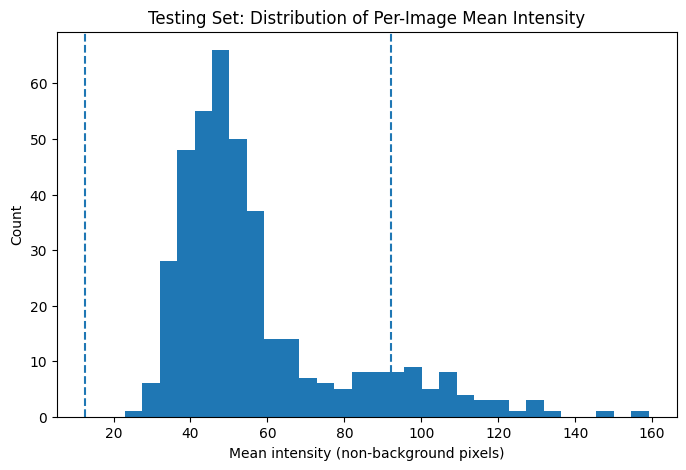

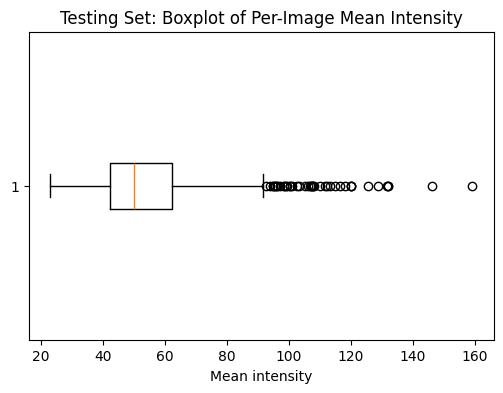


Example potential outliers (testing set):


,path,mean_intensity,dark_frac,bright_frac
245,archive-2/Grayscale_Testing\notumor\Te-no_0296...,92.619606,0.320413,0.038040
235,archive-2/Grayscale_Testing\meningioma\Te-me_0...,94.026733,0.054272,0.070602
308,archive-2/Grayscale_Testing\notumor\Te-no_0162...,94.875374,0.165292,0.040186
277,archive-2/Grayscale_Testing\notumor\Te-no_0281...,94.939171,0.169187,0.042971
259,archive-2/Grayscale_Testing\notumor\Te-no_0375...,95.552368,0.000279,0.021565


In [30]:

# Repeat the same analysis for the grayscale testing set
test_stats_df = collect_image_intensity_stats(grayscale_test_path, max_images=400)

q1_t = test_stats_df["mean_intensity"].quantile(0.25)
q3_t = test_stats_df["mean_intensity"].quantile(0.75)
iqr_t = q3_t - q1_t
lower_bound_t = q1_t - 1.5 * iqr_t
upper_bound_t = q3_t + 1.5 * iqr_t

test_outliers = test_stats_df[
    (test_stats_df["mean_intensity"] < lower_bound_t) |
    (test_stats_df["mean_intensity"] > upper_bound_t)
]

print(f"Total sampled test images: {len(test_stats_df)}")
print(f"Potential outlier test images (IQR rule): {len(test_outliers)}")

plt.figure(figsize=(8, 5))
plt.hist(test_stats_df["mean_intensity"], bins=30)
plt.axvline(lower_bound_t, linestyle="--")
plt.axvline(upper_bound_t, linestyle="--")
plt.title("Testing Set: Distribution of Per-Image Mean Intensity")
plt.xlabel("Mean intensity (non-background pixels)")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(6, 4))
plt.boxplot(test_stats_df["mean_intensity"], vert=False)
plt.title("Testing Set: Boxplot of Per-Image Mean Intensity")
plt.xlabel("Mean intensity")
plt.show()

print('\nExample potential outliers (testing set):')
test_outliers.sort_values("mean_intensity").head()[["path", "mean_intensity", "dark_frac", "bright_frac"]]

The following sections are:
1. Deep learning approach to outlier detection using an Autoencoder  
2. Identification and visualization of outlier images from training and test sets  
3. End‑to‑end training pipeline for the classification task  

